# Mit Ecken und Kanten – Edge Detection mit Convolutions

## Convolutional Neuronal Networks und YOLO v3 
Convolutional Neuronal Networks sind aus der Welt der KI nicht mehr wegzudenken. Ohne sie wäre es zum Beispiel nicht möglich, selbstfahrende Autos zu bauen. Damit sich ein Auto selbständig im Verkehr zurechtfindet, muss es seine Umgebung erkennen. Dazu gehört nicht nur der relativ einfache Fall, ein Objekt, wie zum Beispiel einen Fußgänger als solchen zu erkennen, sondern auch seine Position zu bestimmen. In Bildern beliebig viele Objekte zu erkennen (Klassifikation) und deren Position zu bestimmen, bezeichnet man als Detection. Detection ist quasi die Königsdisziplin im Bereich der Computer Vision. Diese Herausforderung wird zurzeit mit einem Algorithmus bewerkstelligt, der sich YOLO v3 nennt. Die Abkürzung steht für You Only Look Once. Das v3 weist auf die derzeit aktuelle Version drei hin. Mit YOLO ist es möglich Detection bewegter Bilder in Real Time zu bewerkstelligen.

Kern von YOLO ist ein extrem tiefes Convolutional Neuronal Network CNN. Wir haben in anderen Blogs bereits über CNNs gesprochen und gezeigt, wie man sie mit Keras gewinnbringend verbaut:

* [einstieg-in-convolutional-neuronale-netze-mit-keras](https://www.mt-ag.com/einstieg-in-convolutional-neuronale-netze-mit-keras/)
* [so-entwirft-man-ein-top-cnn](https://www.mt-ag.com/so-entwirft-man-ein-top-cnn/)


## Wie war das eigentlich früher?
In diesem Blog möchte ich noch einmal einen Schritt zurückgehen und den mathematischen Hintergrund von Faltungen (Convolutions) zeigen. Dabei ist der Trick so verblüffend einfach, dass man eigentlich nur Plus und Minus verstanden haben muss.

Bevor man maschinelles Lernen für die Bildverarbeitung einsetzte, musste man sich mit analytischen Algorithmen behelfen. Die Algorithmik der Faltungen beschäftigt sich damit, Kanten in Bildern zu erkennen. Der Traum der Wissenschaftler war dabei, dass man einen Gegenstand ein einem Bild lokalisieren könnte, wenn man seine Kanten erkennen würde und den Rest einfach ignoriert. Das ist sowas wie Ausmalen nur andersherum (also quasi „entmalen“). 

Kleiner Einschub: "Es gibt übrigens eine ganze Reihe von Algorithmen, die Kanten erkennen können. Wer sich dafür interessiert, sollte sich zum Beispiel MSER (Maximal Stable External Region) ansehen, ein sehr mächtiges aber auch kompliziertes Verfahren im Bereich der analytischen Lokation."

Beim Falten eines Bildes, lässt man einen kleinen Filter über das Bild gleiten und schreibt mit, was man durch diesen Filter vom Bild noch sieht. Jeder Filter ist auf bestimmte Kanten spezialisiert. Also horizontale, vertikale, gekrümmte, … Kanten. 

Eine Kante ist dabei ein starker hell / dunkel Kontrast im Bild. Trifft der Filter also auf eine Stelle mit einem starken Kontrast soll er heftig „ausschlagen“. Bei schwachen Kontrasten hingegen soll sich der Filter ruhig verhalten. Wie muss so ein Filter also gebaut sein, damit er dieses Verhalten bewerkstelligen kann? 

Um zum Beispiel vertikale Kanten zu erkennen, braucht mal ein Verfahren, dass die Differenz aus allen links / rechts Bildpunkt – Tupeln bildet. Ist die Differenz der Intensität zweier nebeneinander gelegener Bildpunkte besonders groß, muss der Filter dafür auch einen besonders großen Wert liefern. Das hört sich nach einer Art Einheitsmatrix an:

![Abb 1: Filter für vertikale Kanten](filter_v.png)

Nehmen wir an, wir hätten ein sehr kleines Bild mit gerade mal drei auf drei Bildpunkten:

![Abb 2: Sehr kleines Bild](small_sample.png)

Wenn man den 3x3 großen Filter nun auf ein 3x3 großes Bild anwendet, geschieht folgendes:

$$
    \begin{bmatrix}
    80 & 2  & 0 \\
    90 & 80 & 0 \\
    50 & 50 & 4 \\
    \end{bmatrix}
    *
    \begin{bmatrix}
    1 & 0 & -1 \\
    1 & 0 & -1 \\
    1 & 0 & -1 \\
    \end{bmatrix}
    = 
    (80 \cdot 1 + 2 \cdot 0 + 0 \cdot -1) + (90  \cdot 1 + 80 \cdot 0 + 0 \cdot -1) + (50 \cdot 1 + 50 \cdot 0 + 4 \cdot -1) = 
    216
$$

Wir erhalten also ein Maß für den vertikalen Kontrast von 216. Das klingt ehrlich gesagt nicht sehr spannend. Spannend wird es erst, wenn man das Verfahren auf größere Bilder anwendet und den Filter Stück für Stück verschiebt:

![Abb 3: Verschieben des Filters](together.png)

Als Ergebnis erhält man dann eine Matrix, die sich wieder als Bild darstellen lässt:

![Abb 4: Ergebnis](result.png)


## Ein bisschen Python
Um die Faltungen ein wenig ausprobieren zu können, habe ich einige Zeilen Python Code geschrieben. Der Code soll möglichst klar den Algorithmus zeigen, ist aber alles andere als performant.

### Boiler Plate
Zuerst alle nötigen Imports


In [1]:
#numpy
import numpy as np

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# open pictures
from PIL import Image

### Die Filter und ein kleines Beispiel
Ich baue mir jeweils einen Filter für vertikale und horizontale Linien.

In [2]:
filter_v = np.ones((3,3))
filter_v[:,1] = 0
filter_v[:,2] = -1

print("Vertikaler Filter:\n{}".format(filter_v))

filter_h = filter_v.transpose()
print("\nHoriuontaler Filter:\n{}".format(filter_h))

Vertikaler Filter:
[[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]

Horiuontaler Filter:
[[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]


Um die Filter grundlegend ausprobieren zu können, baue ich mir ein simples 100x100 Punkte großes Beispielbild mit einer horizontalen, einer diagonalen und einer vertikalen weißen Linie.

In [3]:
image_test = np.identity(100)*266
image_test[10:12] = 266
image_test[:,10:12] = 266

Um die Bilder einheitlich darstellen zu können, spendiere ich mir eine kleine Hilfsmethode, zum Zeichnen von Bildern. Mit dem shift Parameter kann ich die Bilder ein wenig aufhellen, um mir Deteils besser anzuzeigen.

In [4]:
def show(image, title, shift=0):
    image = image + shift
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    print("{} {}".format(title, image.shape))

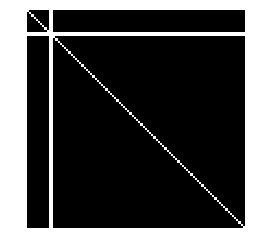

Abb 5: Das Test Bild (100, 100)


In [5]:
show(image_test, "Abb 5: Das Test Bild")

Die eigentliche Faltung des Bildes läuft mit vier ineinander geschachtelten Schleifen über jede Filterposition und summiert die entsprechenden Kontraste auf. Wie bereits erwähnt ist der Code extrem unperformant, zeigt aber dafür sehr schön die Funktionsweise der Filter.

In [6]:
def convolution(image, filter):
    # Anzahl der Spalten im Ergebnis
    pos_x_max = image.shape[1]-filter.shape[1] + 1
    # Anzahl der Zeilen im Ergebnis
    pos_y_max = image.shape[0]-filter.shape[0] + 1

    # Ergebnismatrix vorbereiten
    result = np.zeros((pos_y_max, pos_x_max))

    # Schleife über die Zeilen des Originalbilds
    for pos_y in range(pos_y_max):
        # Schleife über die Spalten des Originalbilds
        for pos_x in range(pos_x_max):
            # den betrachteten Teilausschnitt aus dem Original herausholen ...
            patch = image[pos_y : pos_y+3 , pos_x : pos_x+3]

            res = 0
            # und mit dem Filter ausmultiplizieren
            for n in range(patch.shape[0]):
                for m in range(patch.shape[1]):
                    res = res + patch[n,m] * filter[n,m]
            # Ergebnis in der Ergebnismatrix vermerken
            result[pos_y, pos_x] = res

    return result

Jetzt kann man die beiden Filter auf das Testbild anwenden und sich das Ergebnis anschauen. Der vertikale Filter entfernt erwartungsgemäß den horizontalen Balken und andersherum. Von der Diagonale wird „nur“ ein Teil entfernt, da Diagonalen ja nichts anderes sind als sehr feine Treppen.

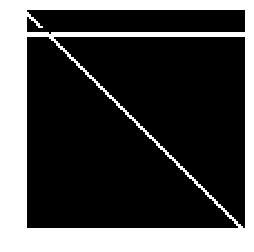

Abb 6: Der horizontale Filter löscht den vertikalen Balken (98, 98)


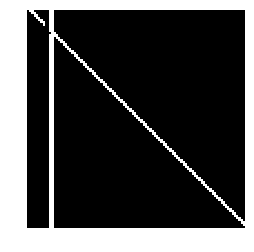

Abb 7: Der vertikale Filter löscht den horizontalen Balken (98, 98)


In [7]:
show(convolution(image_test, filter_h), "Abb 6: Der horizontale Filter löscht den vertikalen Balken")
show(convolution(image_test, filter_v), "Abb 7: Der vertikale Filter löscht den horizontalen Balken")


Nun habe ich mir noch zwei echte Bilder herausgesucht, um die Filter auszuprobieren. Den Effekt finde ich beeindruckend. Es sieht aus, als würde man einen Kupferstich aus den Bildern erzeugen. Beachtenswert ist, dass eben immer die vertikalen oder horizontalen Aspekte der Bilder hervorgehoben werden. Es sieht aus, als würden sie mit einem Schatten versehen.

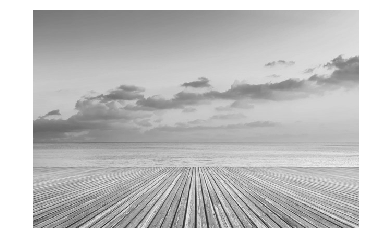

Abb 8: Vertikaler Anleger vor dem Horizont (417, 625)


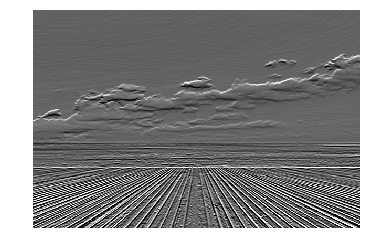

Abb 9: Der horizontale Filter, mit deutlicher Horizontlinie (415, 623)


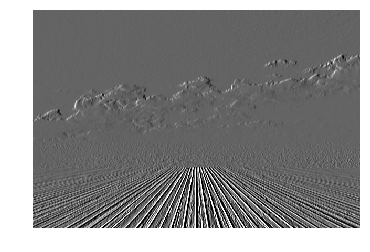

Abb 10: Der vertikale Filter. Der Horizont ist fast nicht zu sehen. (415, 623)


In [8]:
horizon = np.asarray(Image.open('horizont.jfif').convert("L"))
show(horizon, "Abb 8: Vertikaler Anleger vor dem Horizont")
show(convolution(horizon, filter_h), "Abb 9: Der horizontale Filter, mit deutlicher Horizontlinie", shift=100)
show(convolution(horizon, filter_v), "Abb 10: Der vertikale Filter. Der Horizont ist fast nicht zu sehen.", shift=100)

Und zum Schluss, weil es einfach dazugehört: Ein Hund.

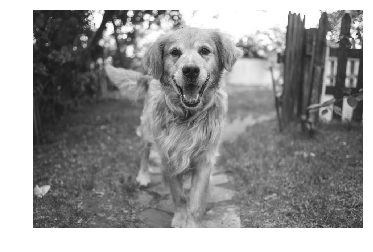

Abb 11: Der Hallo Welt Hund (600, 910)


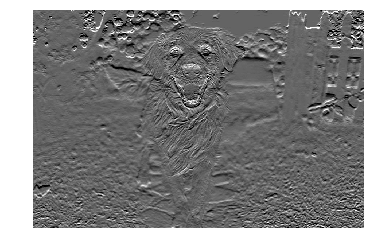

Abb 12: Der horizontale Filter (598, 908)


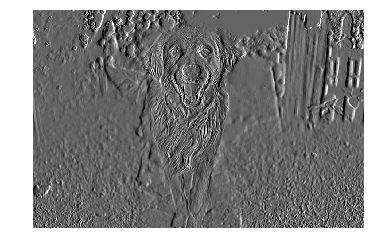

Abb 13: Der vertikale Filter (598, 908)


In [9]:
dog = np.asarray(Image.open('hund.png').convert("L"))
show(dog, "Abb 11: Der Hallo Welt Hund")
show(convolution(dog, filter_h), "Abb 12: Der horizontale Filter", shift=100)
show(convolution(dog, filter_v), "Abb 13: Der vertikale Filter", shift=100)

## Schluss

Es ist erstaunlich wie einfach Kanten aus einem Bild herauszufiltern. Bei den Convolutional Neuronal Network greift man den Gedanken der Filter auf. Der einzige Unterschied besteht nur noch darin, dass man die Werte in den Filter Matrizen durch Gewichte ersetzt und diese dann trainiert. Somit lassen sich alle beschreibenden Ecken und Kanten herausarbeiten.
